Playing ATARI-ram games using python-neat

# Import

In [63]:
import numpy as np
import gym
from gym import wrappers
from __future__ import print_function
import os
%matplotlib inline
import neat
import visualize

# Define config

In [28]:
fc_config_filename = 'fc.config'
game = 'MsPacman-ram-v0'
num_evaluations = 3
num_cores = 3
population_size = 2

# Create environment

In [29]:
env = gym.make(game)

[2017-02-07 15:56:02,287] Making new env: MsPacman-ram-v0


# Create neat-python population

In [35]:
# Load configuration.
config_initial = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation, fc_config_filename)

config_initial.genome_config.num_inputs = env.observation_space.shape[0]
config_initial.genome_config.num_outputs = env.action_space.n
config.pop_size = population_size

In [36]:
game_fc_config_filename = 'fc-' + game + '.config'

config_initial.save(game_fc_config_filename)

config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation, game_fc_config_filename)

# Create the population, which is the top-level object for a NEAT run.
p = neat.Population(config)

# Add reporters

In [37]:
# Add a stdout reporter to show progress in the terminal.
p.add_reporter(neat.StdOutReporter())
stats = neat.StatisticsReporter()
p.add_reporter(stats)
p.add_reporter(neat.Checkpointer(5))

# Define fitness via game score

In [45]:
def transform_observation(observation):
    observation = observation / 255. * 2 - 1
    return observation

# a = argmax_a Q(s,a)
def predict_action(observation, network):
    observation = transform_observation(observation)
    output = network.activate(observation)
    action = np.argmax(output)
    return(action)

# play num_evaluations games, take mean
def evaluate_network(env, network):
    rewards = []
    i = 0
    while i < num_evaluations:
        rewards += [get_reward(env, network)]
        i += 1

    res = np.array(rewards).mean()
    return res

# play 1 game with network
def get_reward(env, network):
    observation = env.reset()
    done = False
    iteration, total_reward = 0, 0
        
    while not done:
        #env.render()
        action = predict_action(observation, network)
        observation, reward, done, info = env.step(action)
        total_reward += reward

        #if iteration % 500 == 0:
        #    print(str(iteration))

        #if total_reward < -12000 or iteration >= 8000:
        #    break

        iteration += 1
        
    return total_reward

def evaluate_genome(genome, config):
    network = neat.nn.FeedForwardNetwork.create(genome, config)
    fitness = evaluate_network(env, network)
    return fitness
    
#print(evaluate_genome(p.species.get_species(1).members[1], config))

evaluator = neat.parallel.ParallelEvaluator(num_workers = num_cores, eval_function = evaluate_genome, timeout = None)

# Run evolution

In [40]:
# Run evolution
winner = p.run(evaluator.evaluate, 1)


 ****** Running generation 1 ****** 

Population's average fitness: 210.00000 stdev: 70.91988
Best fitness: 293.33333 - size: (10, 1147) - species 1 - id 4
Species length: 1 totaling 3 individuals
Species no improv: {1: 0}
Average adjusted fitness: 0.519
Spawn amounts: [3]
Species fitness  : [0.51923076923076927]
Mean genetic distance 0.47344667311, std dev 0.342977054603
Total extinctions: 0
Generation time: 14.539 sec (14.318 average)


# Print results


Output:


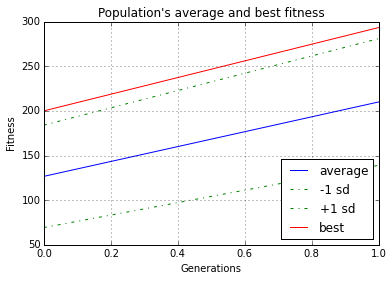

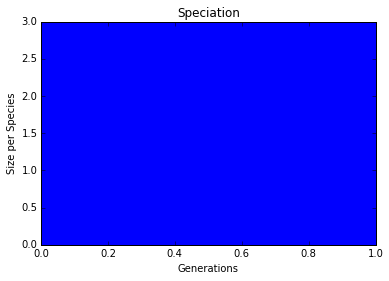

In [67]:
# Display the winning genome.
#print('\nBest genome:\n{!s}'.format(winner))

# Show output of the most fit genome against training data.
print('\nOutput:')
winner_network = neat.nn.FeedForwardNetwork.create(winner, config)
visualize.draw_net(config, winner, True)
visualize.plot_stats(stats, ylog=False, view=True)
visualize.plot_species(stats, view=True)

#p = neat.Checkpointer.restore_checkpoint('neat-checkpoint-4')
#p.run(eval_genomes, 10)

In [51]:
def evaluate_with_video(game, network):
    env_eval = gym.make(game)
    env_eval = wrappers.Monitor(env_eval, '/tmp/' + game + '-eval')
    for i_episode in range(20):
        observation = env_eval.reset()
        total_reward = 0
        while True:
            env_eval.render()
            action = predict_action(observation, network)
            observation, reward, done, info = env_eval.step(action)
            total_reward += reward
            if done:
                print("Episode finished after {0} timesteps reward = {1}".format(t+1, total_reward))
                break

In [52]:
evaluate_with_video(game, winner_network)

[2017-02-07 16:08:33,338] Making new env: MsPacman-ram-v0
[2017-02-07 16:08:33,469] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-02-07 16:08:33,472] Creating monitor directory /tmp/MsPacman-ram-v0-eval
[2017-02-07 16:08:33,530] Starting new video recorder writing to /tmp/MsPacman-ram-v0-eval/openaigym.video.0.19298.video000000.mp4


NoSuchDisplayException: Cannot connect to "None"